# PCA Analysis on Document Embeddings with Metadata

This notebook conducts a PCA (Principal Component Analysis) on the document embeddings extracted from movie review datasets. The embeddings include not only the semantic content of the reviews but also metadata-enriched features.

The primary goal is to understand the contribution of each embedding component to the variance in the dataset and to identify uninformative dimensions that can be pruned for better performance in downstream tasks.

Importing required packages

In [1]:
import subprocess
import sys

# List of required packages
required_packages = [
    "pickle", "numpy", "keybert", "tqdm", "pandas", "torch", "sentence_transformers"
]

def install_package(package):
    """Installs a package using pip if it's not already installed."""
    try:
        __import__(package)
        print(f"{package} is already installed.")
    except ImportError:
        print(f"Installing {package}...")
        subprocess.check_call([sys.executable, "-m", "pip", "install", package])

# Check and install missing packages
for package in required_packages:
    install_package(package)

pickle is already installed.
numpy is already installed.


C:\Users\aless\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


keybert is already installed.
tqdm is already installed.
pandas is already installed.
torch is already installed.
sentence_transformers is already installed.


In [2]:
# Imports and dependencies
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from sentence_transformers import SentenceTransformer
from KeyBertMetadata import KeyBERTMetadata
from sklearn.decomposition import PCA
from collections import defaultdict
import warnings
warnings.filterwarnings('ignore')

### Dataset and Model Initialization

We analyze one or more datasets containing movie reviews. The `KeyBERTMetadata` model is used to generate document embeddings that incorporate both textual and contextual metadata information. For each dataset, only a subset of the reviews is used to keep computations tractable.

In [ ]:
movie_titles = ['../Dataset/Reviews_By_Movie/GoodBadUgly.pkl',
                '../Dataset/Reviews_By_Movie/HarryPotter.pkl',
                '../Dataset/Reviews_By_Movie/IndianaJones.pkl',
                '../Dataset/Reviews_By_Movie/LaLaLand.pkl',
                '../Dataset\\Reviews_By_Movie\\Oppenheimer.pkl',
                '../Dataset/Reviews_By_Movie/Parasite.pkl',
                '../Dataset/Reviews_By_Movie/SW_Episode1.pkl',
                '../Dataset/Reviews_By_Movie/SW_Episode2.pkl',
                '../Dataset/Reviews_By_Movie/SW_Episode3.pkl',
                '../Dataset/Reviews_By_Movie/SW_Episode4.pkl',
                '../Dataset/Reviews_By_Movie/SW_Episode5.pkl',
                '../Dataset/Reviews_By_Movie/SW_Episode6.pkl',
                '../Dataset/Reviews_By_Movie/SW_Episode7.pkl',
                '../Dataset/Reviews_By_Movie/SW_Episode8.pkl',
                '../Dataset/Reviews_By_Movie/SW_Episode9.pkl'
]

model = KeyBERTMetadata(model=SentenceTransformer("all-MiniLM-L6-v2"))
df_subset_length = 2000  # Number of reviews to process from each movie

# List to store average contribution vectors from each movie
all_avg_contributions = []

for file_path in movie_titles:
    with open(file_path, 'rb') as file:
        reviews_df = pickle.load(file)

    movie_title = reviews_df['Movie_Title'].iloc[0]
    #print("Dataset: " + movie_title)

    df_subset = reviews_df.head(df_subset_length)
    metadata = model.extract_metadata(df_subset, alpha=0.3)
    docs = df_subset["Preprocessed_Review"].astype(str).tolist()

    doc_embeddings, _ = model.extract_embeddings_mean(
        docs,
        metadata=metadata,
        optional_pruning=False,
        keyphrase_ngram_range=(1, 2),
        stop_words='english'
    )
    
    # Principal Component Analysis (PCA)

    # PCA is applied to the embedding matrix to identify the dimensions contributing most to the 
    # overall variance. Components with negligible contributions are candidates for pruning.

    pca = PCA(n_components=390)
    pca_result = pca.fit_transform(doc_embeddings)
    loadings = pca.components_
    avg_contribution = np.mean(np.abs(loadings), axis=0)
    top_indices = np.argsort(avg_contribution)[::-1]

    # Store the average contribution vector
    all_avg_contributions.append(avg_contribution)


    # Analysis of Custom and Metadata Dimensions

    # Several dimensions, such as 127, 223, and 319, consistently exhibit negligible contribution 
    # across datasets. These are purely textual components with limited semantic variability, making 
    # them strong candidates for pruning. This observation directly motivated the pruning logic later
    # implemented in the final version of `KeyBERTMetadata`.

    # Conversely, metadata-related dimensions (384–389) show mixed levels of contribution, 
    # with some demonstrating non-trivial influence on the principal components, validating their inclusion.

    low_var_indices = [127, 223, 319]
    meta_indices = [384, 385, 386, 387, 388, 389]

    print('\n')
    print(f"Processing {movie_title}")
    print(f"on {len(df_subset)} reviews...")
    print('\n')

    scale_exponent = -2
    scale_factor = 10 ** scale_exponent

    meta_names = ['utility', 'length', 'polarity', 'recency', 'controversy', 'rating_deviation']
    meta_name_dict = dict(zip(range(384, 390), meta_names))

    # Header
    print(f"{'Dimension':<10} | {'Name':<18} | {'Avg Contribution':>18}")
    print("-" * 52)

    for idx in low_var_indices + meta_indices:
        # Format meta-feature name if present
        name = meta_name_dict.get(idx, "")
        
        # Scale value
        scaled_value = avg_contribution[idx] / scale_factor
        
        # Print formatted row
        print(f"{idx:<10} | {name:<18} | {scaled_value:>14.2f}e{scale_exponent:+03d}")

    print("\n")



# Compute the global mean vector and scalar average
global_avg_contribution_vector = np.mean(all_avg_contributions, axis=0)  # shape (390,)
final_mean_contribution_value = np.mean(global_avg_contribution_vector)  # single scalar




Processing The Good, the Bad and the Ugly
on 1429 reviews...


Dimension  | Name               |   Avg Contribution
----------------------------------------------------
127        |                    |           0.26e-02
223        |                    |           0.26e-02
319        |                    |           0.26e-02
384        | utility            |           1.51e-02
385        | length             |           2.61e-02
386        | polarity           |           2.02e-02
387        | recency            |           2.93e-02
388        | controversy        |           1.17e-02
389        | rating_deviation   |           1.79e-02




Processing Harry Potter and the Sorcerer's Stone
on 2000 reviews...


Dimension  | Name               |   Avg Contribution
----------------------------------------------------
127        |                    |           0.26e-02
223        |                    |           0.26e-02
319        |                    |           0.26e-02
384        | 

## Visual Summary

The chart below visualizes the average contribution of the selected dimensions. It illustrates the gap between metadata dimensions and the least informative textual components.

In [27]:
# --- Final average computation across all films ---

scale_exponent = -2
scale_factor = 10 ** scale_exponent

# ANSI code for bold start and reset
BOLD = "\033[1m"
RESET = "\033[0m"

# Header
print(f"{'Feature':<8} | {'Name':<18} | {'Mean Contribution':>23}")
print("-" * 58)

# Rows
for idx in low_var_indices + meta_indices:
    value = global_avg_contribution_vector[idx]
    name = meta_name_dict.get(idx, "")
    scaled = value / scale_factor
    bold_number = f"{BOLD}{scaled:>16.2f}e{scale_exponent:+03d}{RESET}"
    print(f"{idx:<8} | {name:<18} | {bold_number}")

print()  # empty line before final average

# Compute and print global mean contribution
final_mean_contribution_value = np.mean(global_avg_contribution_vector)
scaled_final = final_mean_contribution_value / scale_factor
bold_final = f"{BOLD}{scaled_final:>16.2f}e{scale_exponent:+03d}{RESET}"

print(f"{'':<4} {'Global Mean Contribution':<18} | {bold_final}")

Feature  | Name               |       Mean Contribution
----------------------------------------------------------
127      |                    |             0.28e-02
223      |                    |             0.28e-02
319      |                    |             0.26e-02
384      | utility            |             1.82e-02
385      | length             |             2.69e-02
386      | polarity           |             2.39e-02
387      | recency            |             2.67e-02
388      | controversy        |             1.35e-02
389      | rating_deviation   |             1.41e-02

     Global Mean Contribution |             3.95e-02


### Computation of Average Contributions

This cell performs all necessary computations to prepare the data for visualization:

- Selects specific **custom** and **metadata** feature indices.
- Extracts their **absolute average contributions** from the global vector.
- Applies **scientific scaling** (e.g., ×10⁻²) for consistent formatting.
- Assigns **semantic labels** to metadata dimensions where available.
- Prepares a dictionary (`plot_data`) containing all relevant values for plotting, including the final global average contribution.

The actual visualization is handled separately in the following cell.


In [25]:
custom_indices = [127, 223, 319, 384, 385, 386, 387, 388, 389]

# Extract avg contributions
avg_contribs = [global_avg_contribution_vector[idx] for idx in custom_indices]

# Create DataFrame for the custom indices
df = pd.DataFrame({
    "Dimension Index": custom_indices,
    "Avg Contribution (abs)": avg_contribs,
})

# Add names, empty string if none
df["Name"] = df["Dimension Index"].map(meta_name_dict).fillna("")

# Add the final mean contribution as a separate row with a fake index so we can track it
final_row = pd.DataFrame({
    "Dimension Index": ["Final Avg"],
    "Avg Contribution (abs)": [final_mean_contribution_value],
    "Name": [""]
})

# Combine final mean row with the others
full_df = pd.concat([df, final_row], ignore_index=True)

# Sort descending by contribution value
full_df = full_df.sort_values("Avg Contribution (abs)", ascending=False).reset_index(drop=True)

# Prepare labels for y-axis
def format_label(row):
    if row["Dimension Index"] == "Final Avg":
        return "Mean Contribution"
    elif row["Name"]:
        return f"{row['Dimension Index']} ({row['Name']})"
    else:
        return str(row["Dimension Index"])

y_labels = full_df.apply(format_label, axis=1)

# Scaling to e-2 for nicer print
scale_exp = -2
scale_factor = 10 ** scale_exp

scaled_vals = full_df["Avg Contribution (abs)"] / scale_factor
max_val = full_df["Avg Contribution (abs)"].max()


### Interpretation of PCA Contribution Plot

This bar plot shows the **average absolute contribution** of selected dimensions (metadata and pruning candidates) to the principal components.

**Legend:**
- 🟧 **Mean contribution computed on all dimensions**  
  The orange reference line and label mark the overall average contribution across the entire feature space.
- 🟦 **Contribution of Metadata dimensions**  
  Metadata-related features such as utility, length, polarity, etc.
- 🟩 **Contribution of candidate dimensions for pruning**  
  Dimensions manually selected for evaluation based on low variance or other heuristics.

**Note:** Contribution values are scaled and presented in scientific notation (e.g., `1.65e-02`) to ensure comparability.


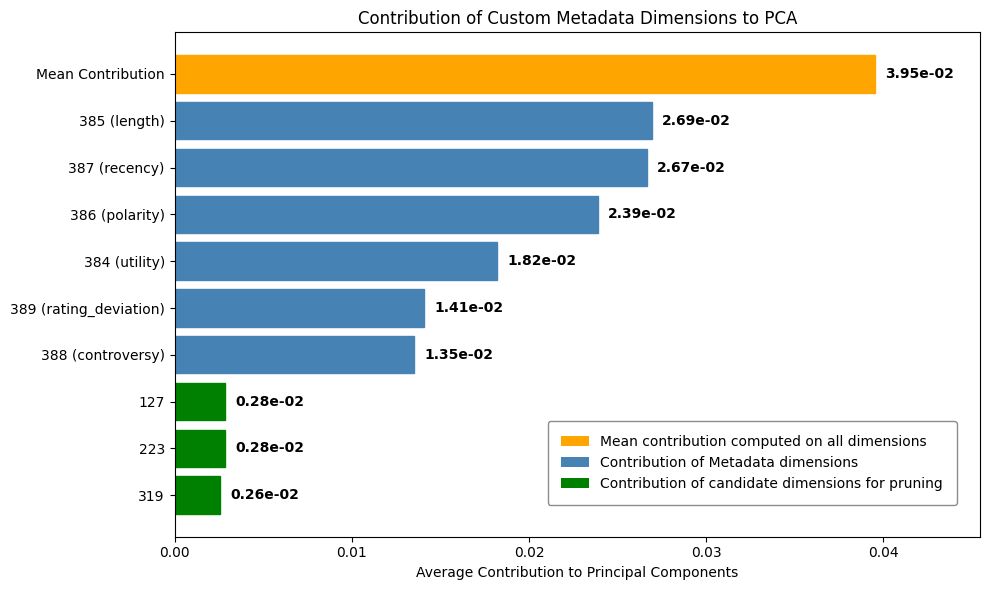

In [26]:
fig, ax = plt.subplots(figsize=(10, 6))
bars = ax.barh(y_labels, full_df["Avg Contribution (abs)"], color='steelblue')

# Coloring bars according to category
for i, (idx, name) in enumerate(zip(full_df["Dimension Index"], full_df["Name"])):
    bar = bars[i]
    if idx == "Final Avg":
        bar.set_color("orange")
    elif name == "":
        bar.set_color("green")
    else:
        bar.set_color("steelblue")

ax.set_xlabel("Average Contribution to Principal Components")
ax.set_title("Contribution of Custom Metadata Dimensions to PCA")
ax.set_xlim(0, max_val * 1.15)

# Add scaled contribution values next to bars
for bar, val in zip(bars, scaled_vals):
    width = bar.get_width()
    y = bar.get_y() + bar.get_height() / 2
    offset = max_val * 0.015
    ax.text(
        width + offset,
        y,
        f"{val:.2f}e{scale_exp:+03d}",
        va='center',
        ha='left',
        fontsize=10,
        fontweight='bold',
        color='black'
    )

plt.gca().invert_yaxis()  # Highest value on top

# Add explanatory text inside plot
legend_elements = [
    Patch(facecolor='orange', label='Mean contribution computed on all dimensions'),
    Patch(facecolor='steelblue', label='Contribution of Metadata dimensions'),
    Patch(facecolor='green', label='Contribution of candidate dimensions for pruning')
]

# Add custom legend inside the plot (axes coords from 0 to 1)
ax.legend(
    handles=legend_elements,
    loc='lower right',
    frameon=True,
    framealpha=0.9,
    facecolor='white',
    edgecolor='gray',
    fontsize=10,
    bbox_to_anchor=(0.98, 0.05),  # Position inside the axes
    borderpad=1,
    title_fontsize=11
)

plt.tight_layout()
plt.show()
